# Bimonial regression alternatives to Logistic regression

If we have a very large dataset it can be computationally expensive to train a logistic regression model.
If we have categorical features or can convert features into categories we can summiarise the data and fit a binomial regression model instead, which are more data efficient.

Here we we show their equivalence and how they scale.


First lets create a data generating function

In [1]:
from typing import Tuple
import numpy as np
import polars as pl


def generate_data(
    n_samples: int = 1000,
    n_features: int = 4,
    seed: int = None,
) -> Tuple[pl.DataFrame, np.array]:
    rand = np.random.default_rng(seed)

    # binary covariates
    covariates = rand.integers(0, 2, size=(n_samples, n_features))

    weights = rand.normal(size=(n_features, 1))
    outcome_logit = np.dot(covariates, weights) + rand.normal(
        scale=0.1, size=(n_samples, 1)
    )

    def inv_logit(p):
        return np.exp(p) / (1 + np.exp(p))

    outcome_prob = inv_logit(outcome_logit)
    outcome = rand.binomial(n=1, p=outcome_prob)

    df = pl.concat(
        [
            pl.DataFrame(outcome, schema=["y"]),
            pl.DataFrame(outcome_prob, schema=["y_prob"]),
            pl.DataFrame(covariates, schema=[f"x_{idx}" for idx in range(n_features)]),
        ],
        how="horizontal",
    )

    return df, weights


df, weights = generate_data(n_samples=1000, n_features=2, seed=0)
print("Data sample:")
display(df.head())

print("weights:")
print(weights.flatten())


Data sample:


y,y_prob,x_0,x_1
i64,f64,i64,i64
0,0.768634,1,1
0,0.539129,1,0
0,0.464949,0,0
1,0.433964,0,0
1,0.708297,0,1


weights:
[0.08365798 0.8965755 ]


Lets fit a logistic regression model first. We predict the outcome column `y` from the `x` columns and we retrieve estimated weights that are close to the true weights:

In [2]:
import statsmodels.api as sm

logit_model = sm.Logit(
    df["y"].to_pandas(), df.drop(columns=["y", "y_prob"]).to_pandas()
)
logit_model_results = logit_model.fit()
logit_model_results.summary()


Optimization terminated successfully.
         Current function value: 0.643229
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.03417
Time:                        10:41:17   Log-Likelihood:                -643.23
converged:                       True   LL-Null:                       -665.99
Covariance Type:            nonrobust   LLR p-value:                 1.512e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_0            0.0825      0.105      0.786      0.432      -0.123       0.288
x_1            0.8720      0.109      8.003      0.000       0.658       1.086
==============================================================================
"""

Lets fit with a Binomial model. First we need to group the data into counts of success and failure against each combination of the input categories:

In [3]:
def group_data(df: pl.DataFrame):
    x_cols = [col for col in df.columns if "x_" in col]
    return df.groupby(x_cols).agg(
        [
            pl.col("y").sum().alias("success"),
            (pl.count() - pl.col("y").sum()).alias("failure"),
        ]
    )


df_group = group_data(df)
df_group


x_0,x_1,success,failure
i64,i64,i64,i64
0,0,102,115
1,0,138,118
0,1,193,74
1,1,183,77


Now we can fit a Binomial regression model. We get identical results to the logistic regression model, including confidence intervals.

In [4]:
binom_model = sm.GLM(
    df_group[["success", "failure"]].to_pandas(),
    df_group.drop(columns=["success", "failure"]).to_pandas(),
    family=sm.families.Binomial(),
)
binom_model_results = binom_model.fit()
binom_model_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     ['success', 'failure']   No. Observations:                    4
Model:                                GLM   Df Residuals:                        2
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -12.717
Date:                    Thu, 10 Aug 2023   Deviance:                       1.9577
Time:                            10:41:17   Pearson chi2:                     1.96
No. Iterations:                         4   Pseudo R-squ. (CS):              1.000
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_0            0.0825      0.105      0.786      0.432      -0.123       0.288
x_1            0.8720      0.109      8.003      0.000       0.658       1.086
==============================================================================
"""

## Fitting time/data scaling

Now that we've shown their equivalence how does each model scale with data size?

We can test the fitting time on different number of samples to find out. We will not include the time for grouping the data as this can commonly be done via external tools such as data warehouses.

In [5]:
import timeit
import tqdm


times = []
n_features = 10
n_trials = 10
for n_samples in tqdm.tqdm([1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]):
    for _trial in range(n_trials):
        _n_samples = int(n_samples)
        df, weights = generate_data(n_samples=_n_samples, n_features=10, seed=_n_samples+_trial)

        if _n_samples < 1e6:
            t1 = timeit.default_timer()
            logit_model = sm.Logit(
                df["y"].to_pandas(), df.drop(columns=["y", "y_prob"]).to_pandas()
            )
            logit_model_results = logit_model.fit(disp=0)
            times.append(["logit", _n_samples, timeit.default_timer() - t1])

        df_group = group_data(df=df)
        t1 = timeit.default_timer()
        binom_model = sm.GLM(
            df_group[["success", "failure"]].to_pandas(),
            df_group.drop(columns=["success", "failure"]).to_pandas(),
            family=sm.families.Binomial(),
        )
        binom_model_results = binom_model.fit()
        times.append(["binomial", _n_samples, timeit.default_timer() - t1])

times = pl.DataFrame(times, schema=["model_type", "n_samples", "fit_time"])


  0%|          | 0/11 [00:00<?, ?it/s]

/Users/stantoon/miniconda3/envs/project_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 11/11 [00:33<00:00,  3.08s/it]


Plotting the results show that the Logistic regression model scales exponentially whilst the Binomial is approximately flat.
The shaded region represents the confidence interval of the mean fit time.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_90987/2954676713.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_90987/2954676713.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


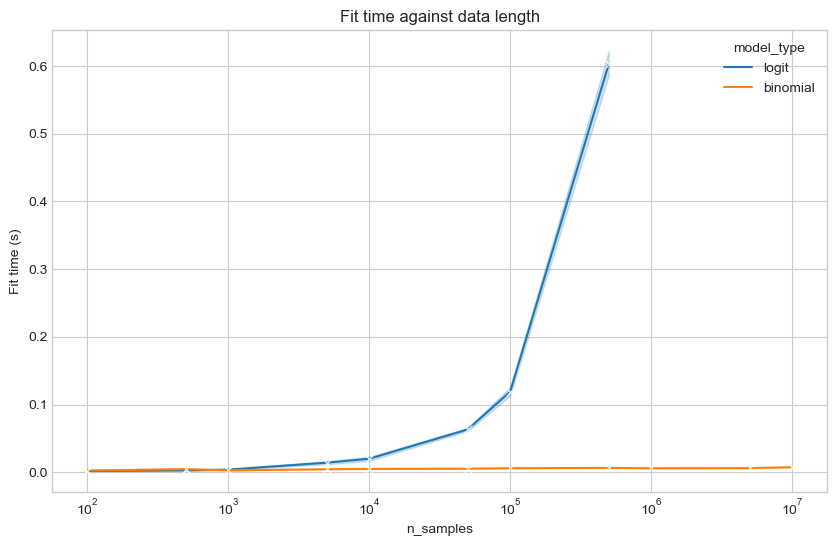

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=times, x="n_samples", y="fit_time", hue="model_type", ax=ax, marker="x"
)
ax.set(xscale="log", ylabel="Fit time (s)", title="Fit time against data length")
fig.show()


The data size passed to the Binomial model always has the same upper group which is the number of possible groups in the data. If we have $n$ features we have $2^n$ possible groups. The counts for each group simply increase when our data size is larger, so we don't expect any change in fitting time. Therefore the Binomial model can scale very well to large problems if we have categorical features. If we don't have categorical features this won't apply, but we can always approximate continuous features with binary categories, such as through various sklearn transformers ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html), [link2](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html)). What's convenient here is that it allows us to do the heavy lifting and aggregation on a data warehouse and output a small dataset for modelling. Therefore we are not limited by the memory of our device used for building models.

Note: there are alternative approaches for logistic regression to handle large data, such as fitting on a sample, though this will bias the confidence intervals to be larger than reality.